We will now import all the libraries needed for training process. It will use Tensorflow backend and keras at frontend.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import random
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Upload dataset to drive and Link Your Google Drive for faster run
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import io

zip_file_path = '/content/drive/My Drive/IMG_dataset.zip'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('IMG')

We wil use datadir as the name given to the folder itself and take the parameters itself. Using head, we will show the first five values for the CSV on the desired format.

In [ ]:
columns = ["center", "left", "right", "steering", "throttle", "reverse", "speed"]
csv_file_path = 'driving_log.csv'
data = pd.read_csv(csv_file_path, names=columns)
pd.set_option("display.max_colwidth", -1)
data.head()

center  \
0  Desktop\track1data\IMG\center_2019_04_02_19_25_33_671.jpg   
1  Desktop\track1data\IMG\center_2019_04_02_19_25_33_743.jpg   
2  Desktop\track1data\IMG\center_2019_04_02_19_25_33_816.jpg   
3  Desktop\track1data\IMG\center_2019_04_02_19_25_33_887.jpg   
4  Desktop\track1data\IMG\center_2019_04_02_19_25_33_959.jpg   

                                                      left  \
0  Desktop\track1data\IMG\left_2019_04_02_19_25_33_671.jpg   
1  Desktop\track1data\IMG\left_2019_04_02_19_25_33_743.jpg   
2  Desktop\track1data\IMG\left_2019_04_02_19_25_33_816.jpg   
3  Desktop\track1data\IMG\left_2019_04_02_19_25_33_887.jpg   
4  Desktop\track1data\IMG\left_2019_04_02_19_25_33_959.jpg   

                                                      right  steering  \
0  Desktop\track1data\IMG\right_2019_04_02_19_25_33_671.jpg  0.0        
1  Desktop\track1data\IMG\right_2019_04_02_19_25_33_743.jpg  0.0        
2  Desktop\track1data\IMG\right_2019_04_02_19_25_33_816.jpg  0.0        
3  Desktop\track1data\IMG\right_2019_04_02_19_25_33_887.jpg  0.0        
4  Desktop\track1data\IMG\right_2019_04_02_19_25_33_959.jpg  0.0        

   throttle  reverse     speed  
0  0.000000  0.0      0.000011  
1  0.000000  0.0      0.000007  
2  0.000000  0.0      0.000003  
3  0.048016  0.0      0.002267  
4  0.281203  0.0      0.175589

As this is picking up the entire path from the local machine, we need to use ntpath function to get the network path assigned. We will declare a name path_leaf and assign accordingly.

In [ ]:
import ntpath

def pathleaf(path):
    head, tail = ntpath.split(path)
    return tail

data["center"] = data["center"].apply(pathleaf)
data["left"] = data["left"].astype(str).apply(pathleaf)
data["right"] = data["right"].astype(str).apply(pathleaf)
data.to_csv('driving_log.csv', index=False, header=False)
data.head()


center                              left  \
0  center_2019_04_02_19_25_33_671.jpg  left_2019_04_02_19_25_33_671.jpg   
1  center_2019_04_02_19_25_33_743.jpg  left_2019_04_02_19_25_33_743.jpg   
2  center_2019_04_02_19_25_33_816.jpg  left_2019_04_02_19_25_33_816.jpg   
3  center_2019_04_02_19_25_33_887.jpg  left_2019_04_02_19_25_33_887.jpg   
4  center_2019_04_02_19_25_33_959.jpg  left_2019_04_02_19_25_33_959.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2019_04_02_19_25_33_671.jpg  0.0       0.000000  0.0      0.000011  
1  right_2019_04_02_19_25_33_743.jpg  0.0       0.000000  0.0      0.000007  
2  right_2019_04_02_19_25_33_816.jpg  0.0       0.000000  0.0      0.000003  
3  right_2019_04_02_19_25_33_887.jpg  0.0       0.048016  0.0      0.002267  
4  right_2019_04_02_19_25_33_959.jpg  0.0       0.281203  0.0      0.175589

We will bin the number of values where the number will be equal to 25 (odd number aimed to get center distribution). We will see the histogram using the np.histogram option on data frame ‘steering’, we will divide it to the number of bins. We keep samples at 400 and then we draw a line. We see the data is centered along the middle that is 0.

In [ ]:
num_bins = 25
samples_per_bin = 2000

# Replace NaN values in the "steering" column with a specific value (e.g., 0)
data["steering"].fillna(0, inplace=True)

# Calculate the histogram
hist, bins = np.histogram(data["steering"], num_bins)
print(bins)

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


Plot on it

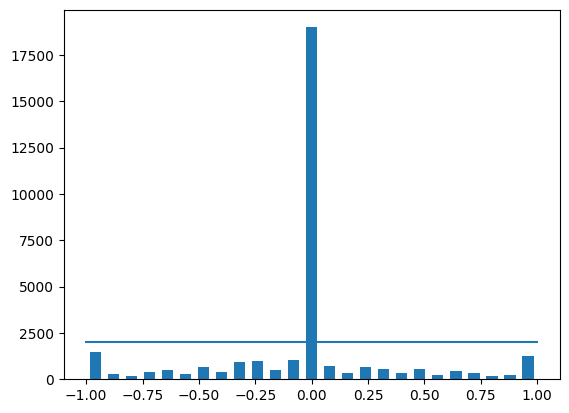

In [ ]:
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot(
    (np.min(data["steering"]), np.max(data["steering"])),
    (samples_per_bin, samples_per_bin),
)


In [ ]:
print("Total Data:", len(data))

Total Data: 32443


We wil specify a variable rove_list.We will specify samples we want to remove using looping construct through every single bin we will iterate through all the steering data. We will shuffle the data and romve some from it as it is now uniformly structured after shuffling.The output will be the distribution of steering angle that are much more uniform. There are significant amount of left steering angle and right steering angle eliminating the bias to drive straight all the time.

In [ ]:
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data["steering"])):
        if data["steering"][i] >= bins[j] and data["steering"][i] <= bins[j + 1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
print("Removed:", len(remove_list))

Removed: 16997


In [ ]:
data.drop(data.index[remove_list], inplace=True)

In [ ]:
print("Remaining:", len(data))


Remaining: 15446


Plot on it

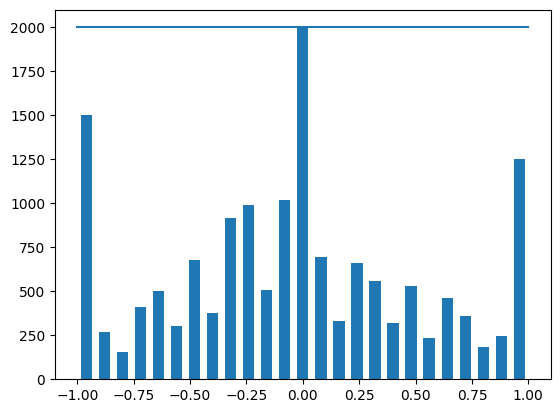

In [ ]:
hist, _ = np.histogram(data["steering"], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot(
    (np.min(data["steering"]), np.max(data["steering"])),
    (samples_per_bin, samples_per_bin),
)

In [ ]:
print(data.iloc[0])

center      center_2019_04_02_19_25_33_671.jpg
left        left_2019_04_02_19_25_33_671.jpg  
right       right_2019_04_02_19_25_33_671.jpg 
steering    0.0                               
throttle    0.0                               
reverse     0.0                               
speed       0.000011                          
Name: 0, dtype: object


In [ ]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        image_path.append(os.path.join(datadir, left.strip()))
        steering.append(float(indexed_data[3]) + 0.15)
        image_path.append(os.path.join(datadir, right.strip()))
        steering.append(float(indexed_data[3]) - 0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

We will be splitting the image path as well as storing arrays accordingly.

In [ ]:
image_paths, steerings = load_img_steering("IMG/IMG", data)
X_train, X_valid, y_train, y_valid = train_test_split(
    image_paths, steerings, test_size=0.2, random_state=6
)
print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))


Training Samples: 37070
Valid Samples: 9268


We will have the histograms now.

Text(0.5, 1.0, 'Validation set')

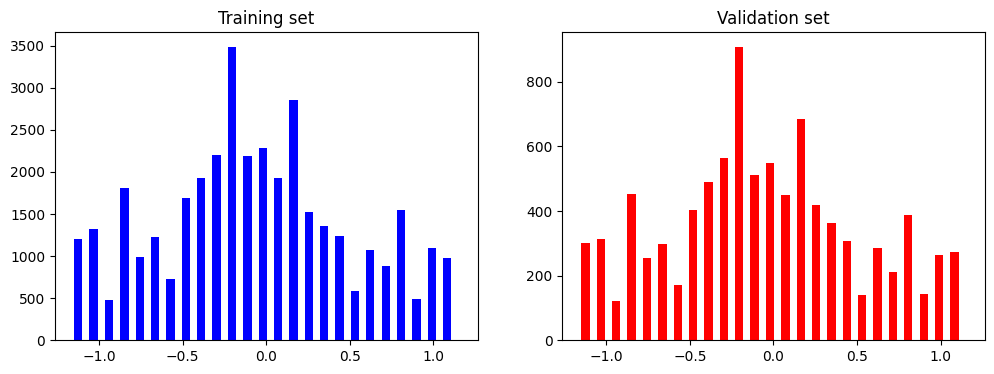

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color="blue")
axes[0].set_title("Training set")
axes[1].hist(y_valid, bins=num_bins, width=0.05, color="red")
axes[1].set_title("Validation set")

In the next steps, we normalize the data and in the nvdia model, we will have to keep it in a UAV pattern as well as slice unnecessary information. We preprocess the image too.

Zoom.The images in the dataset have relevant features in the lower part where the road is visible. The external environment above a certain image portion will never be used to determine the output and thus can be cropped. Approximately, 30% of the top portion of the image is cut and passed in the training set. The snippet of code and transformation of an image after cropping and resizing it to original image can be seen in below.

Text(0.5, 1.0, 'Zoomed Image')

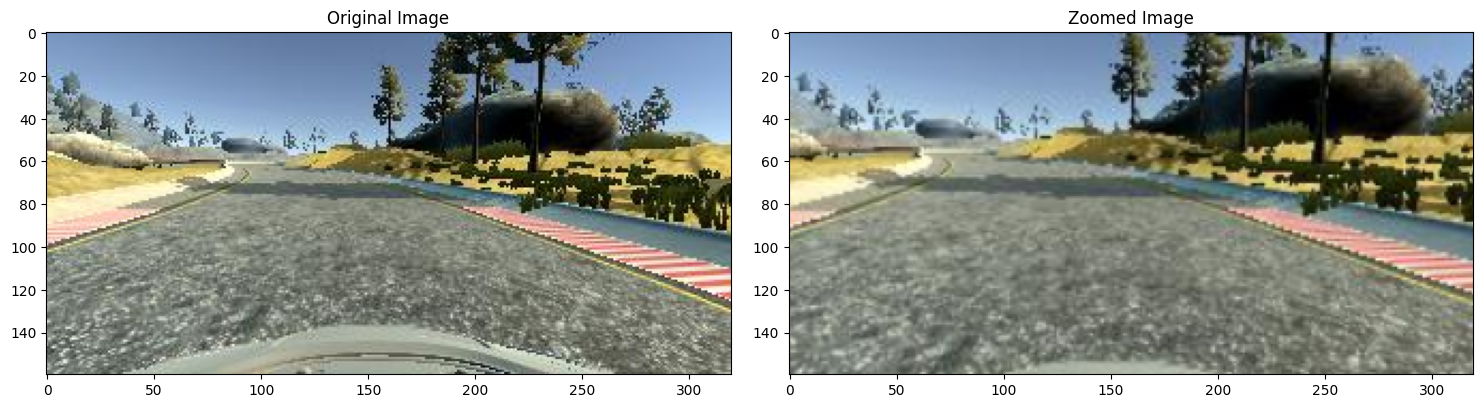

In [ ]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

random_index = random.randint(0, 2500)
image = image_paths[random_index]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(zoomed_image)
axs[1].set_title("Zoomed Image")

Text(0.5, 1.0, 'Panned Image')

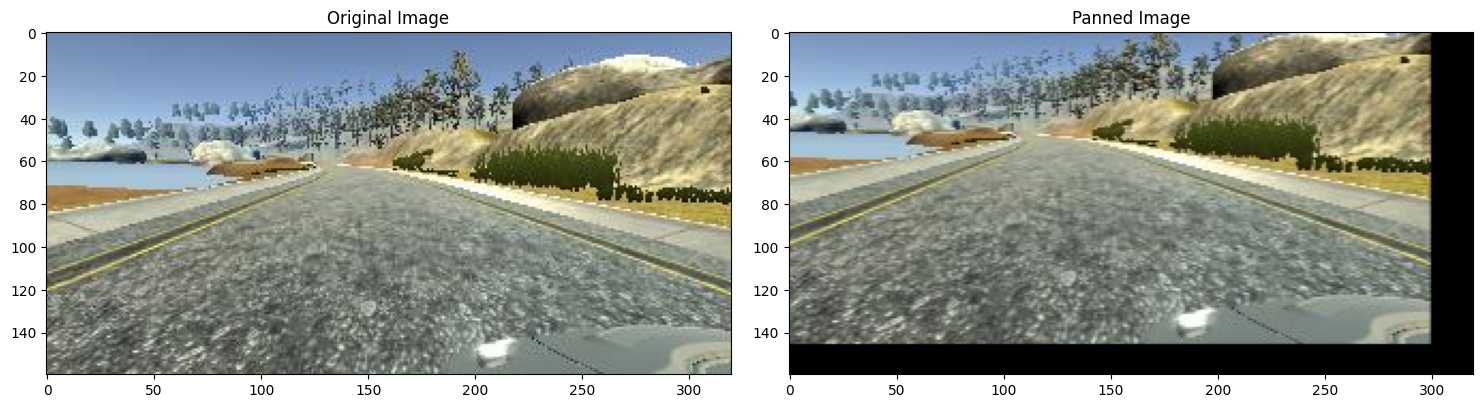

In [ ]:
def pan(image):
    pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image


random_index = random.randint(0, 2500)
image = image_paths[random_index]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(panned_image)
axs[1].set_title("Panned Image")

Brightness.To generalize to the weather conditions with bright sunny day or cloudy, lowlight conditions, the brightness augmentation can prove to be very useful. The code snippet and increase of brightness can be seen below. Similarly, I have randomly also lowered down the level of brightness for other conditions.

Text(0.5, 1.0, 'Brightness altered image ')

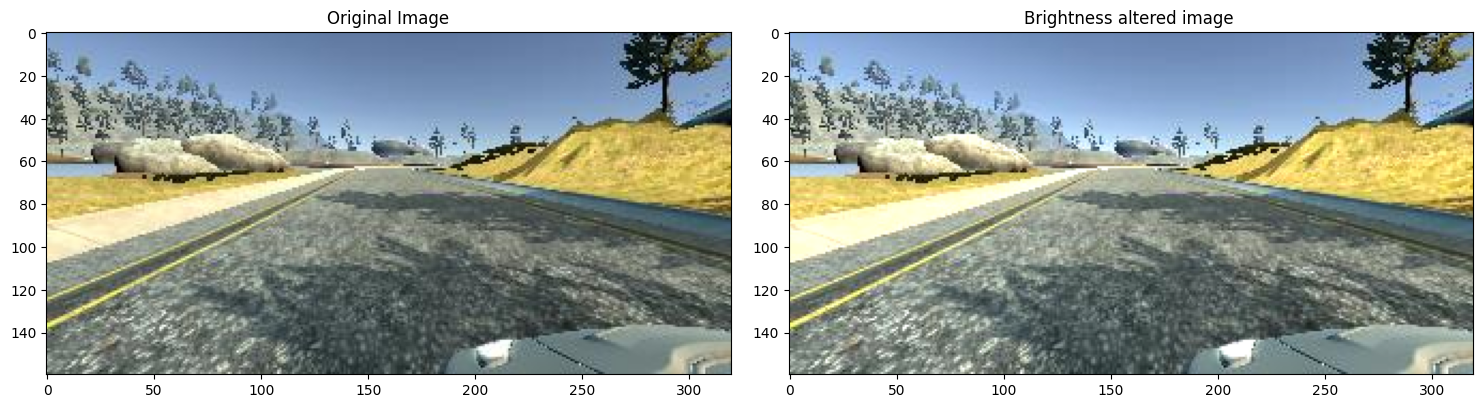

In [ ]:
def random_brightness(image):
    brightness = iaa.Multiply((0.4, 1.2))
    image = brightness.augment_image(image)
    return image


random_index = random.randint(0, 2500)
image = image_paths[random_index]
original_image = mpimg.imread(image)
brightness_altered_image = random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(brightness_altered_image)
axs[1].set_title("Brightness altered image ")

Flip(horizontal).The image is flipped horizontally (i.e. a mirror image of the original image is passed to the dataset). The motive behind this is that the model gets trained for similar kinds of turns on opposite sides too. This is important because Track 1 includes only left turns. The snippet of code and transformation of an image after flipping it can be seen in below.

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.35')

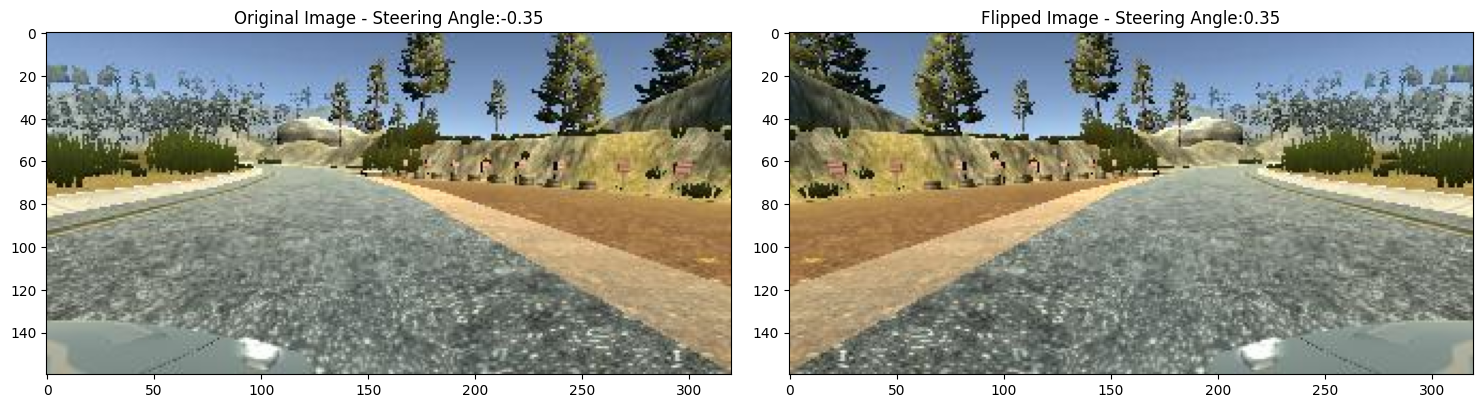

In [ ]:

def random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle


random_index = random.randint(0, 2500)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image - " + "Steering Angle:" + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title("Flipped Image - " + "Steering Angle:" + str(flipped_steering_angle))

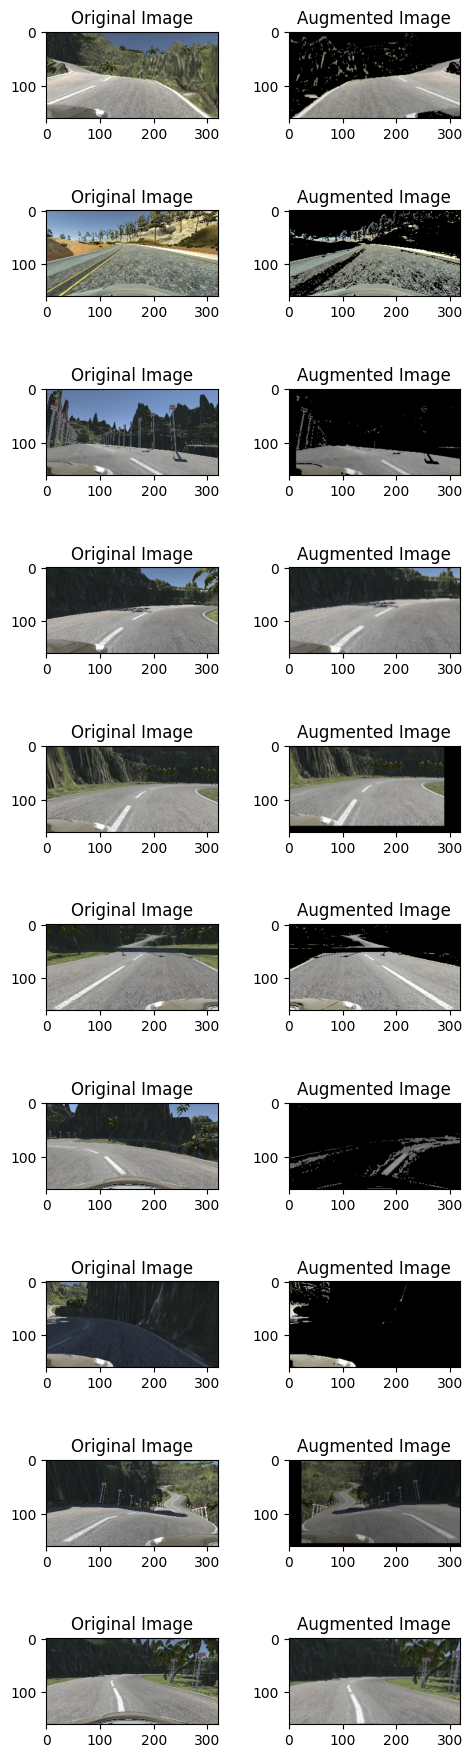

In [ ]:
def highlight_road(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_color = np.array([0, 0, 100])
    upper_color = np.array([179, 50, 255])

    # Create a binary mask for the road
    road_mask = cv2.inRange(hsv_image, lower_color, upper_color)

    # Apply the mask to the original image
    road_highlighted = cv2.bitwise_and(image, image, mask=road_mask)

    return road_highlighted

def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = random_flip(image, steering_angle)
    if np.random.rand() < 0.5:
        image = highlight_road(image)
    return image, steering_angle


ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(5, 18))
fig.tight_layout()

for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]

    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)

    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")

    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")


We continued by doing some image processing. We cropped the image to remove the unnecessary features, changes the images to YUV format, used gaussian blur, decreased the size for easier processing and normalized the values.

In [ ]:
def img_preprocess(img):
    ## Crop image to remove unnecessary features
    img = img[60:135, :, :]
    ## Change to YUV image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    ## Gaussian blur
    img = cv2.GaussianBlur(img, (3, 3), 0)
    ## Decrease size for easier processing
    img = cv2.resize(img, (200, 66))
    ## Normalize values
    img = img / 255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

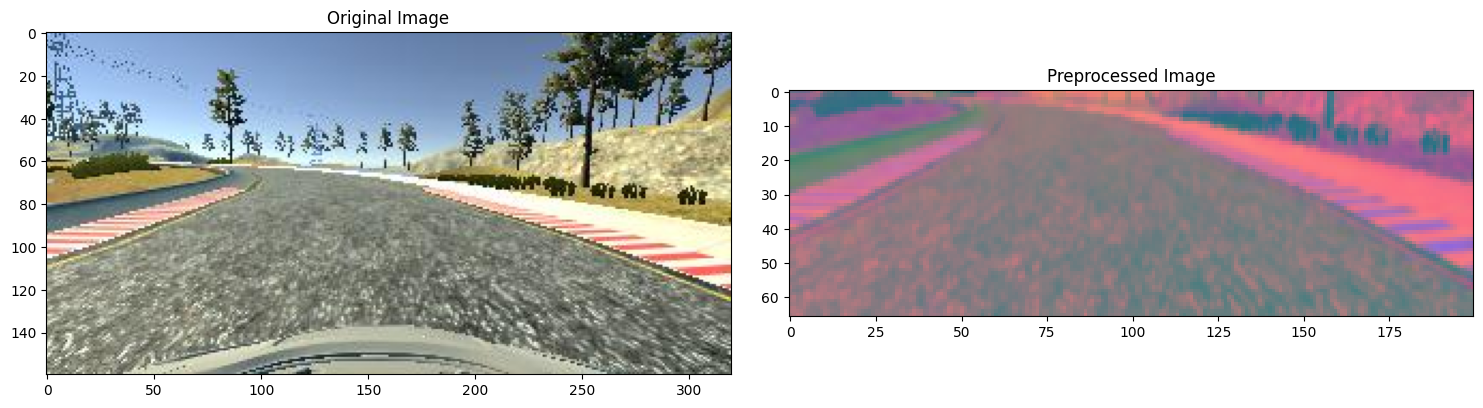

In [ ]:
random_index = random.randint(0, 2500)
image = image_paths[random_index]
original_image = mpimg.imread(image)

preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(preprocessed_image)
axs[1].set_title("Preprocessed Image")

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)

            if istraining:
                im, steering = random_augment(
                    image_paths[random_index], steering_ang[random_index]
                )

            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]

            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)

        yield (np.asarray(batch_img), np.asarray(batch_steering))

Then we converted all the images into numpy array

37070 9268


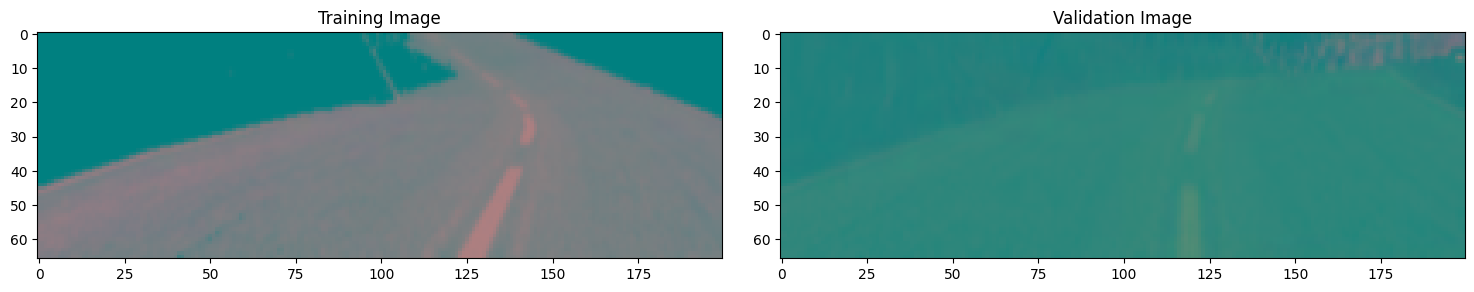

In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title("Training Image")

axs[1].imshow(x_valid_gen[0])
axs[1].set_title("Validation Image")


print(len(X_train), len(X_valid))



```
# This is formatted as code
```

 With behavioural cloning, our dataset is much more complex then any dataset we have used. We are dealing with images that have (200,66) dimensions. Our current datset has approximately 90000 images to train. Our behavioural cloning code has simply has to return appropriate steering angle which is a regression type example. For these things, we need a more advanced model which is provided by nvdia and known as nvdia model.

![title](https://www.researchgate.net/profile/Mathew-Monfort/publication/301648615/figure/fig4/AS:357938163142666@1462350516717/CNN-architecture-The-network-has-about-27-million-connections-and-250-thousand.png)

For defining the model architecture, we need to define the model object. Normalization state can be skipped as we have already normalized it. We will add the convolution layer. As compared to the model, we will organize accordingly. The Nvdia model uses 24 filters in the layer along with a kernel of size 5,5. We will introduce sub sampling. The function reflects to stride length of the kernel as it processes through an image, we have large images. Horizontal movement with 2 pixels at a time, similarly vertical movement to 2 pixels at a time. As this is the first layer, we have to define input shape of the model too i.e., (66,200,3) and the last function is an activation function that is “elu”.

Revisting the model, we see that our second layer has 36 filters with kernel size (5,5) same subsampling option with stride length of (2,2) and conclude this layer with activation ‘elu’.

We added extra layers to NVDIA inorder to reduce loss and improve performance.

Next we add a flatten layer. We will take the output array from previous convolution neural network to convert it into a one dimensional array so that it can be fed to fully connected layer to follow.

Our last convolution layer outputs an array shape of (1,18) by 64.

We end the architecture of Nvdia model with a dense layer containing a single output node which will output the predicted steering angle for our self driving car. Now we will use model.compile() to compile our architecture as this is a regression type example the metrics that we will be using will be mean squared error and optimize as Adam. We will be using relatively a low learning rate that it can help on accuracy. We will use dropout layer to avoid overfitting the data. Dropout Layer sets the input of random fraction of nodes to “0” during each update. During this, we will generate the training data as it is forced to use a variety of combination of nodes to learn from the same data. We will have to separate the convolution layer from fully connected layer with a factor of 0.5 is added so it converts 50 percent of the input to 0. We Will define the model by calling the nvdia model itself. Now we will have the model training process.To define training parameters, we will use model.fit(), we will import our training data X_Train, training data ->y_train, we have less data on the datasets we will require more epochs to be effective. We will use validation data and then use Batch size.

In [ ]:
def NvidiaModel():
  model = Sequential()
  model.add(Convolution2D(24,(5,5),strides=(2,2),input_shape=(66,200,3),activation="elu"))
  model.add(Convolution2D(36,(5,5),strides=(2,2),activation="elu"))
  model.add(Convolution2D(48,(5,5),strides=(2,2),activation="elu"))
  model.add(Convolution2D(64,(3,3),activation="elu"))
  model.add(Convolution2D(64,(3,3),activation="elu"))

  model.add(Flatten())
  model.add(Dense(100,activation="elu"))
  model.add(Dropout(0.5))
  model.add(Dense(50,activation="elu"))
  model.add(Dropout(0.5))
  model.add(Dense(10,activation="elu"))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.compile(optimizer=Adam(learning_rate=1e-3),loss="mse")
  return model



In [ ]:
model = NvidiaModel()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

In [ ]:
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam

def lr_schedule(epoch):
    """
    Learning rate schedule function.
    Adjust the learning rate based on the current epoch.
    """
    initial_lr = 1e-3
    if epoch < 10:
        return initial_lr
    elif 10 <= epoch < 20:
        return initial_lr * 0.1  # Reduce the learning rate by a factor of 10
    else:
        return initial_lr * 0.01  # Further reduce the learning rate

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
history = model.fit_generator(
    batch_generator(X_train, y_train, 100, 1),
    steps_per_epoch=300,
    epochs=15,
    validation_data=batch_generator(X_valid, y_valid, 100, 0),
    validation_steps=200,
    verbose=1,
    shuffle=1,
    callbacks=[lr_scheduler]
)

Epoch 1/15
300/300 [==============================] - 181s 552ms/step - loss: 0.3192 - val_loss: 0.2478 - lr: 0.0010
Epoch 2/15
300/300 [==============================] - 162s 540ms/step - loss: 0.2741 - val_loss: 0.2388 - lr: 0.0010
Epoch 3/15
300/300 [==============================] - 156s 521ms/step - loss: 0.2613 - val_loss: 0.2255 - lr: 0.0010
Epoch 4/15
300/300 [==============================] - 155s 520ms/step - loss: 0.2555 - val_loss: 0.2207 - lr: 0.0010
Epoch 5/15
300/300 [==============================] - 153s 512ms/step - loss: 0.2558 - val_loss: 0.2115 - lr: 0.0010
Epoch 6/15
300/300 [==============================] - 162s 540ms/step - loss: 0.2579 - val_loss: 0.2116 - lr: 0.0010
Epoch 7/15
300/300 [==============================] - 159s 532ms/step - loss: 0.2539 - val_loss: 0.2325 - lr: 0.0010
Epoch 8/15
300/300 [==============================] - 153s 513ms/step - loss: 0.2495 - val_loss: 0.2085 - lr: 0.0010
Epoch 9/15
300/300 [==============================] - 173s 577ms

We can have dead relu this is when a node in neural network essentially dies and only feeds a value of zero to nodes which follows it. We will change from relu to elu. Elu function has always a chance to recover and fix it errors means it is in a process of learning and contributing to the model. We will plot the model and then save it accordingly in h5 format for a keras file.

Text(0.5, 0, 'Epoch')

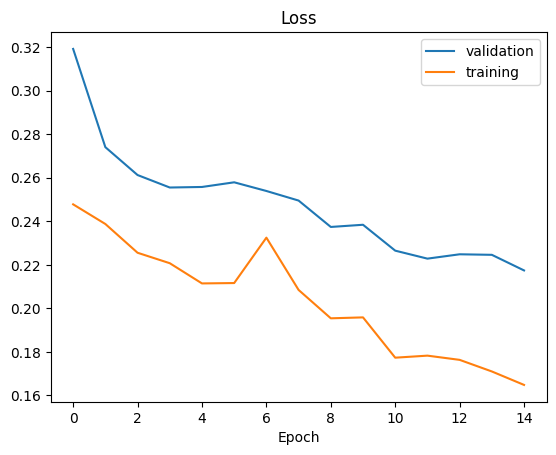

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["validation", "training"])
plt.title("Loss")
plt.xlabel("Epoch")

Save model

In [ ]:
# Save Model for testing purposes
model.save('model.h5')

1/1 [==============================] - 0s 29ms/step


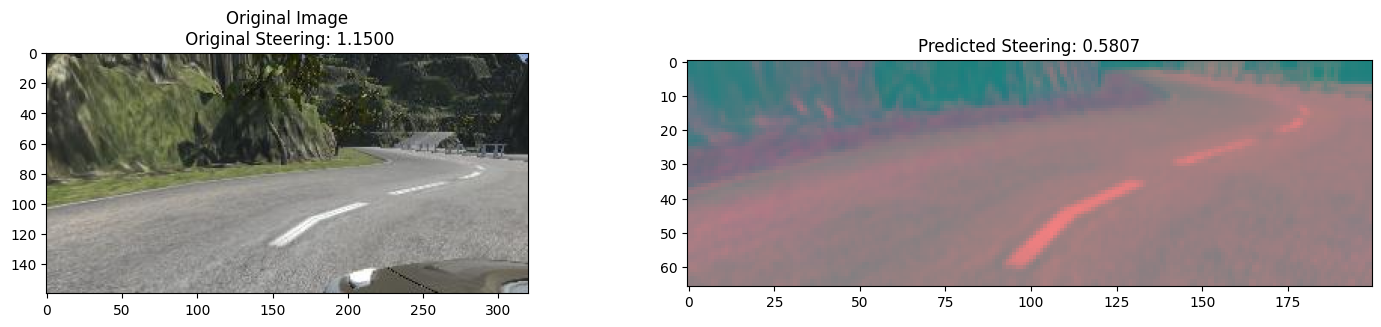

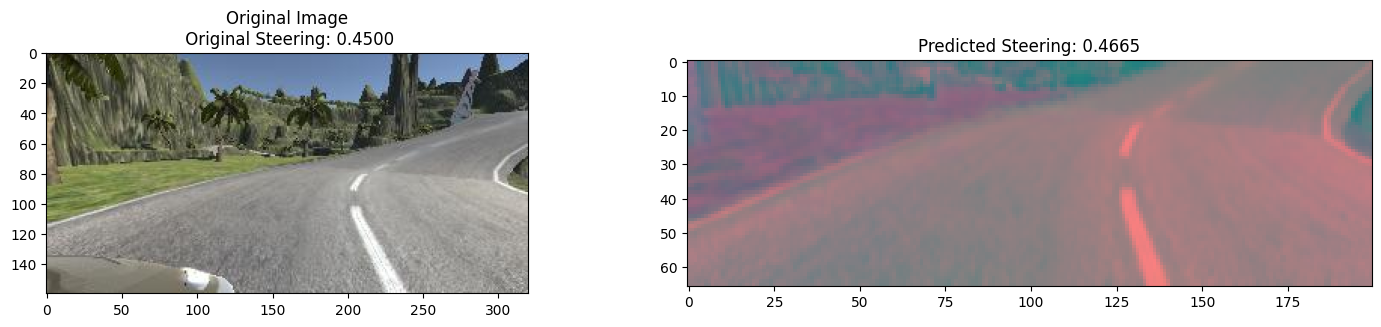

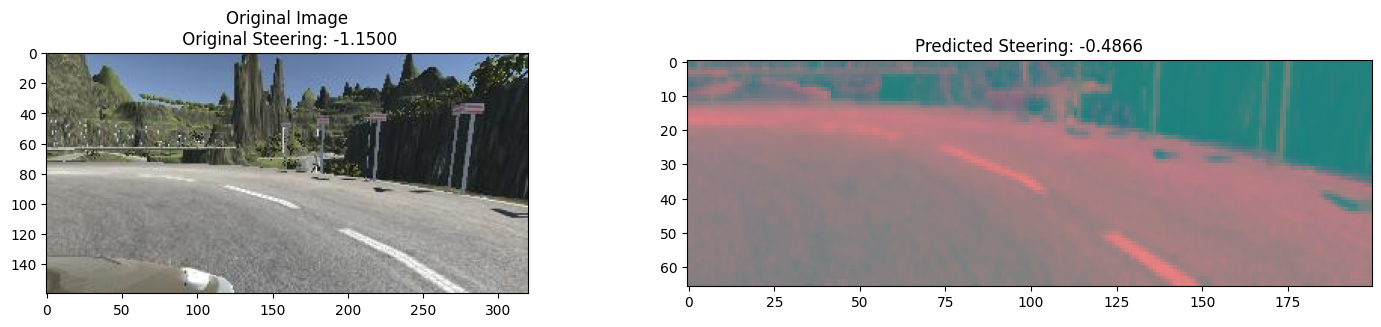

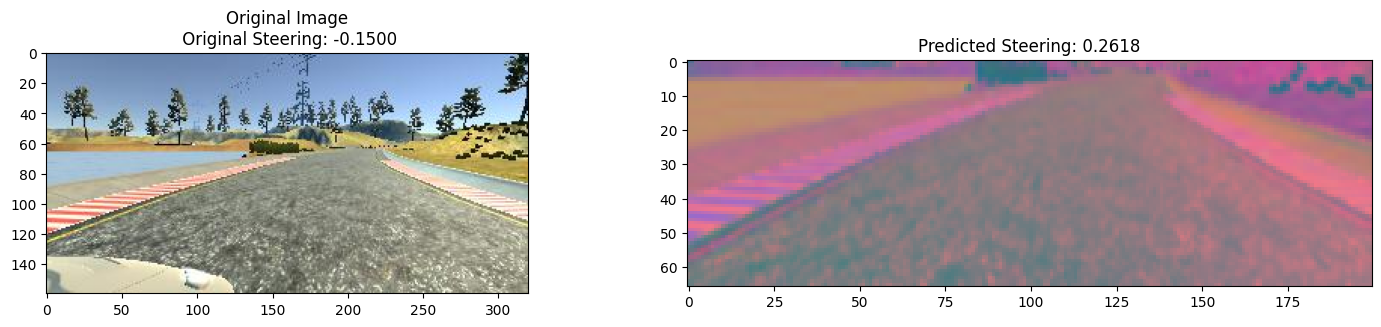

In [ ]:
#Now we check our model on some images

def preprocess_image(image_path):
    img = mpimg.imread(image_path)
    img = img_preprocess(img)
    return img

for i in range(4):
  random_index = i
  random_image_path = X_valid[random_index]
  random_steering_angle = y_valid[random_index]

  random_image = preprocess_image(random_image_path)

  # Reshape the image to match the model's expected input shape
  input_image = random_image.reshape(1, 66, 200, 3)

  # Make the prediction
  predicted_steering = model.predict(input_image)

  fig, axs = plt.subplots(1, 2, figsize=(15, 3))
  fig.tight_layout()

  axs[0].imshow(mpimg.imread(random_image_path))
  axs[0].set_title("Original Image\n Original Steering: {:.4f}".format(random_steering_angle))

  axs[1].imshow(random_image.squeeze())
  axs[1].set_title("Predicted Steering: {:.4f}".format(predicted_steering[0][0]))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 3, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 100)               128100    
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 50)                5050      
                                                                 
 dropout_7 (Dropout)         (None, 50)               

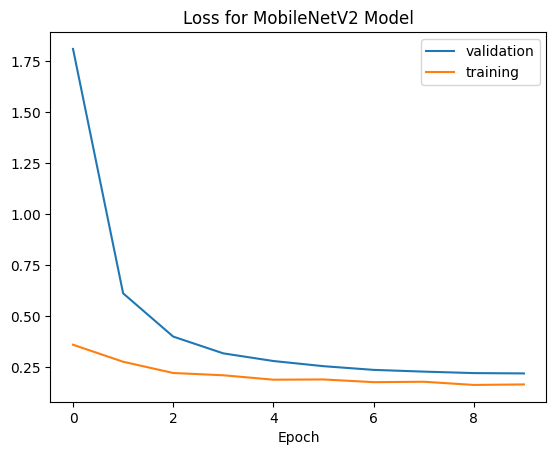

In [34]:


import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint

# Model definition with MobileNetV2 base
def create_mobilenet_model():
    base_model = MobileNetV2(
        include_top=False, weights='imagenet', input_shape=(66, 200, 3)
    )
    base_model.trainable = False

    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(100, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(50, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])

    model.compile(optimizer=Adam(lr=1e-3), loss='mse')

    return model

# Create the MobileNetV2 model
mobilenet_model = create_mobilenet_model()
print(mobilenet_model.summary())

# Model training
mobilenet_checkpoint = ModelCheckpoint(
    'best_mobilenet_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1
)

history_mobilenet = mobilenet_model.fit(
    batch_generator(X_train, y_train, 100, 1),
    steps_per_epoch=len(X_train)//100,
    epochs=10,
    validation_data=batch_generator(X_valid, y_valid, 100, 0),
    validation_steps=len(X_valid)//100,
    callbacks=[mobilenet_checkpoint],
    verbose=1,
    shuffle=True
)

# Plot training history for the MobileNetV2 model
plt.plot(history_mobilenet.history['loss'])
plt.plot(history_mobilenet.history['val_loss'])
plt.legend(["validation", "training"])
plt.title('Loss for MobileNetV2 Model')
plt.xlabel('Epoch')
plt.show()


1/1 [==============================] - 0s 34ms/step


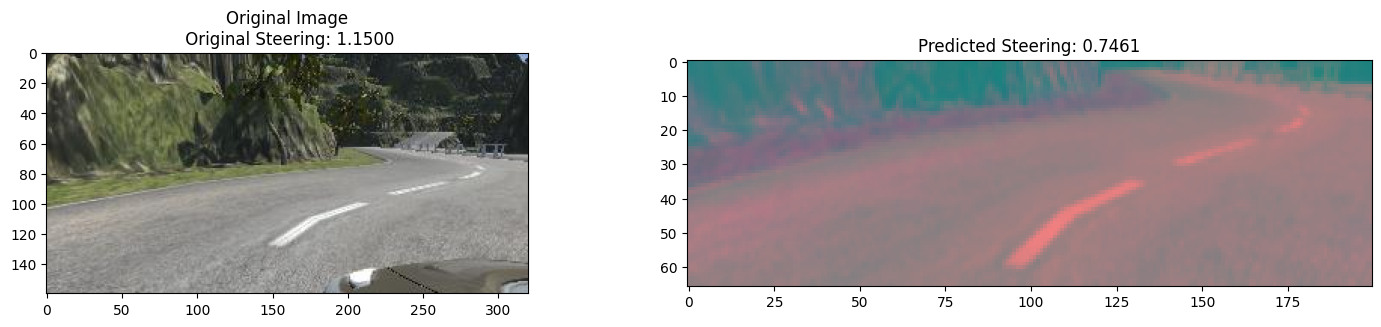

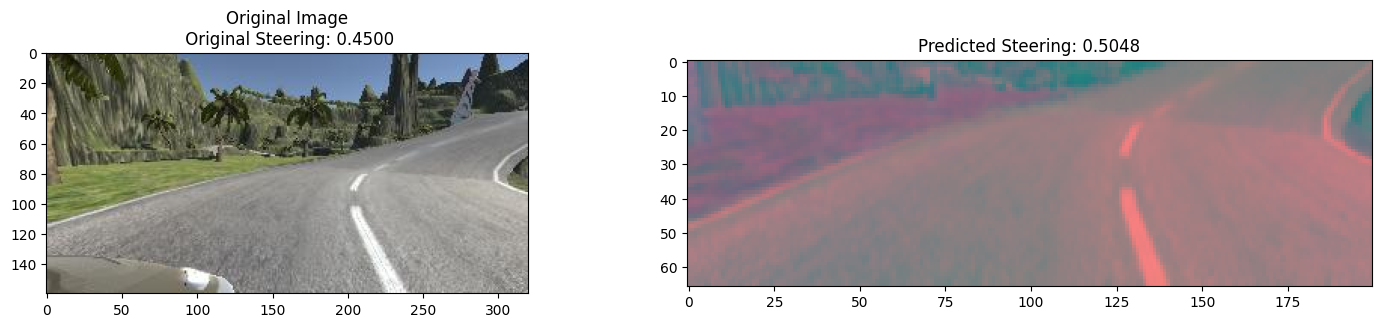

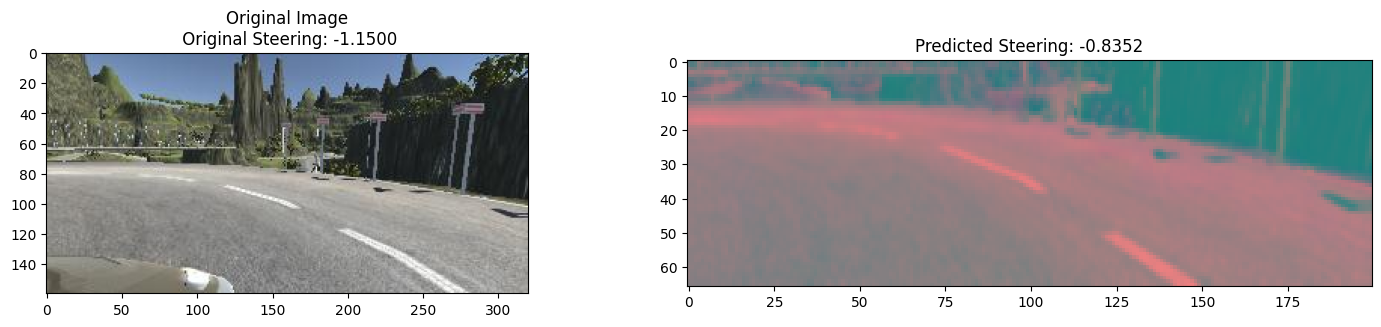

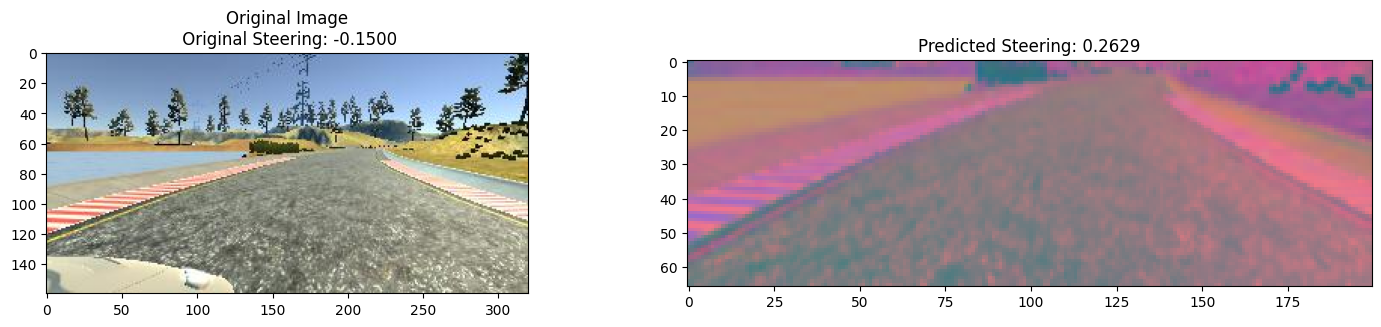

In [35]:

def preprocess_image(image_path):
    img = mpimg.imread(image_path)
    img = img_preprocess(img)
    return img

for i in range(4):
  random_index = i
  random_image_path = X_valid[random_index]
  random_steering_angle = y_valid[random_index]

  random_image = preprocess_image(random_image_path)

  # Reshape the image to match the model's expected input shape
  input_image = random_image.reshape(1, 66, 200, 3)

  # Make the prediction
  predicted_steering = mobilenet_model.predict(input_image)

  fig, axs = plt.subplots(1, 2, figsize=(15, 3))
  fig.tight_layout()

  axs[0].imshow(mpimg.imread(random_image_path))
  axs[0].set_title("Original Image\n Original Steering: {:.4f}".format(random_steering_angle))

  axs[1].imshow(random_image.squeeze())
  axs[1].set_title("Predicted Steering: {:.4f}".format(predicted_steering[0][0]))

In [36]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout

def CustomModel():
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(6, (5, 5), activation="relu", input_shape=(66, 200, 3)))
    model.add(Dropout(0.5))
    model.add(Conv2D(12, (5, 5), activation="relu"))
    model.add(Dropout(0.5))

    # Flatten layer
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(120, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(84, activation="relu"))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(1))  # For regression, no activation function

    # Compile the model with Mean Absolute Error (MAE) loss function
    model.compile(optimizer='adam', loss='mae')

    return model

# Create an instance of the CustomModel
custom_model = CustomModel()

# Display the model summary
print(custom_model.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 196, 6)        456       
                                                                 
 dropout_9 (Dropout)         (None, 62, 196, 6)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 58, 192, 12)       1812      
                                                                 
 dropout_10 (Dropout)        (None, 58, 192, 12)       0         
                                                                 
 flatten_1 (Flatten)         (None, 133632)            0         
                                                                 
 dense_12 (Dense)            (None, 120)               16035960  
                                                                 
 dropout_11 (Dropout)        (None, 120)              

Epoch 1/10
370/370 [==============================] - ETA: 0s - loss: 0.4611
Epoch 1: val_loss improved from inf to 0.43232, saving model to custom_model.h5
370/370 [==============================] - 184s 489ms/step - loss: 0.4611 - val_loss: 0.4323
Epoch 2/10
370/370 [==============================] - ETA: 0s - loss: 0.4061
Epoch 2: val_loss improved from 0.43232 to 0.38332, saving model to custom_model.h5
370/370 [==============================] - 168s 456ms/step - loss: 0.4061 - val_loss: 0.3833
Epoch 3/10
370/370 [==============================] - ETA: 0s - loss: 0.3835
Epoch 3: val_loss improved from 0.38332 to 0.35258, saving model to custom_model.h5
370/370 [==============================] - 163s 443ms/step - loss: 0.3835 - val_loss: 0.3526
Epoch 4/10
370/370 [==============================] - ETA: 0s - loss: 0.3702
Epoch 4: val_loss improved from 0.35258 to 0.32524, saving model to custom_model.h5
370/370 [==============================] - 165s 447ms/step - loss: 0.3702 - val_l

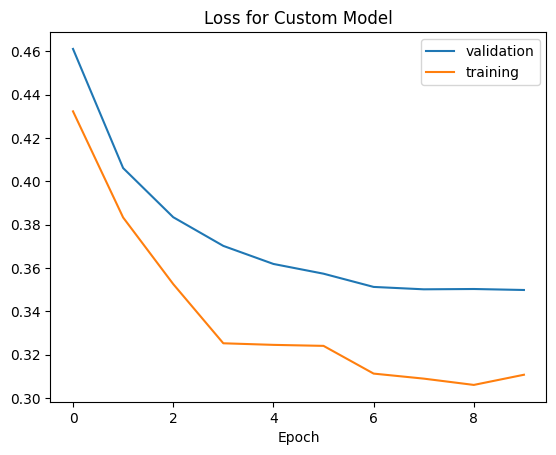

In [37]:
# Model training
custom_checkpoint = ModelCheckpoint(
    'custom_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1
)

history_custom = custom_model.fit(
    batch_generator(X_train, y_train, 100, 1),
    steps_per_epoch=len(X_train)//100,
    epochs=10,
    validation_data=batch_generator(X_valid, y_valid, 100, 0),
    validation_steps=len(X_valid)//100,
    callbacks=[custom_checkpoint],
    verbose=1,
    shuffle=True
)

# Plot training history for the Custom model
plt.plot(history_custom.history['loss'])
plt.plot(history_custom.history['val_loss'])
plt.legend(["validation", "training"])
plt.title('Loss for Custom Model')
plt.xlabel('Epoch')
plt.show()

1/1 [==============================] - 0s 33ms/step


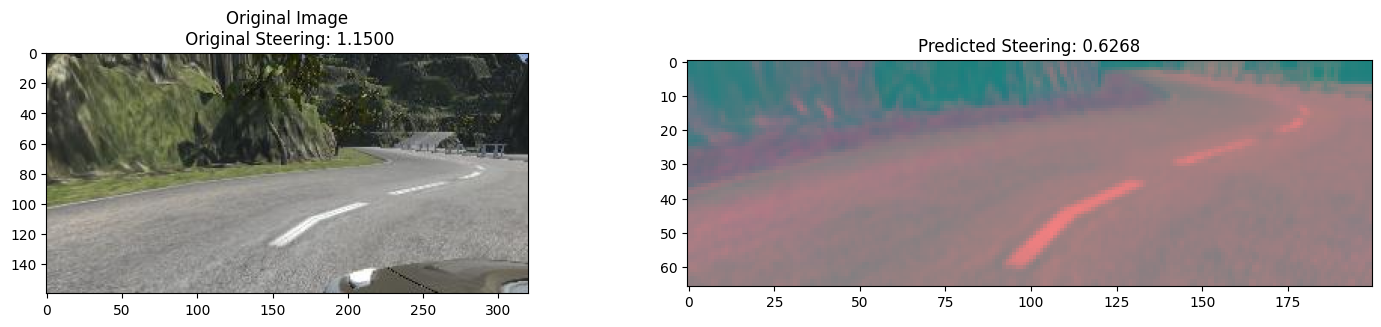

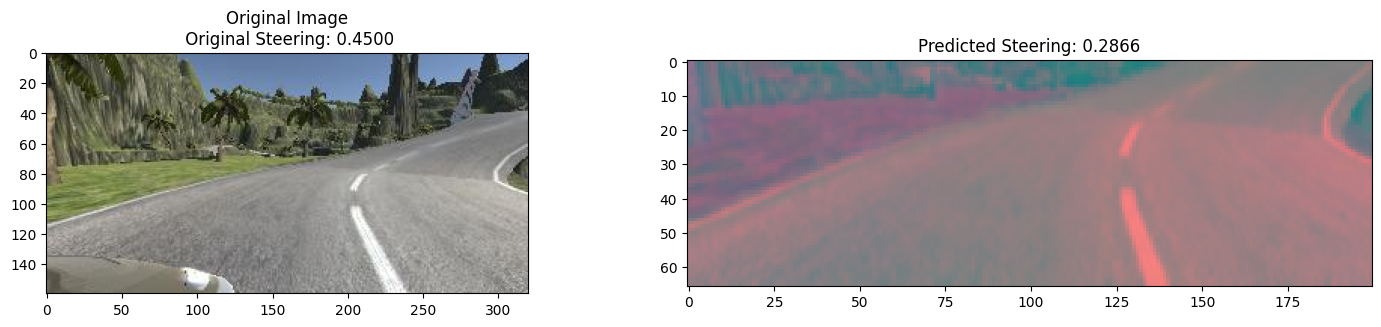

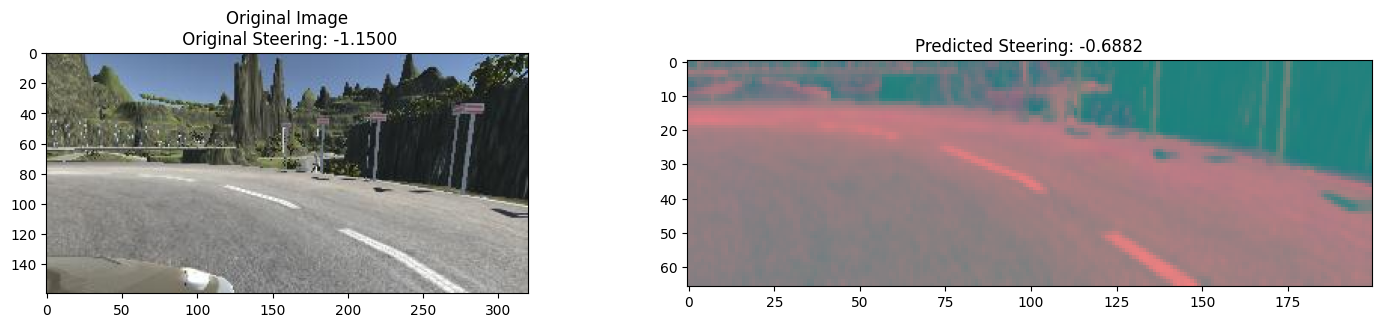

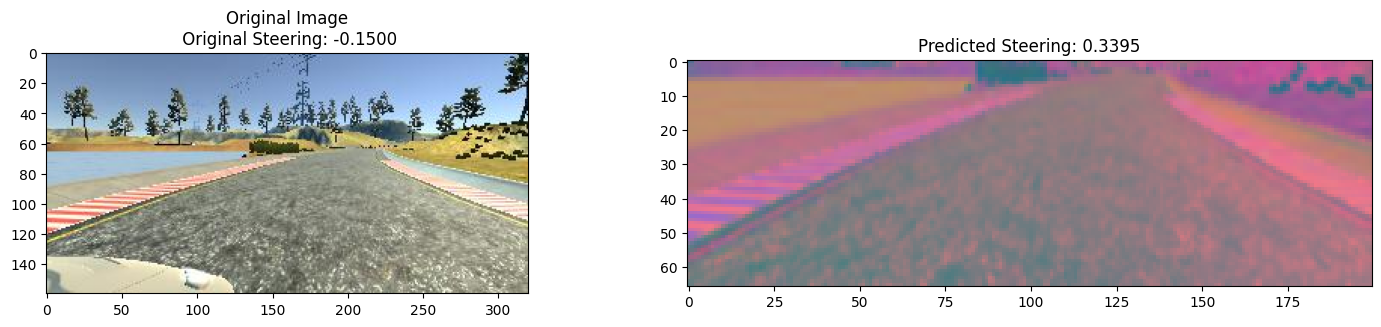

In [38]:

def preprocess_image(image_path):
    img = mpimg.imread(image_path)
    img = img_preprocess(img)
    return img

for i in range(4):
  random_index = i
  random_image_path = X_valid[random_index]
  random_steering_angle = y_valid[random_index]

  random_image = preprocess_image(random_image_path)

  # Reshape the image to match the model's expected input shape
  input_image = random_image.reshape(1, 66, 200, 3)

  # Make the prediction
  predicted_steering = custom_model.predict(input_image)

  fig, axs = plt.subplots(1, 2, figsize=(15, 3))
  fig.tight_layout()

  axs[0].imshow(mpimg.imread(random_image_path))
  axs[0].set_title("Original Image\n Original Steering: {:.4f}".format(random_steering_angle))

  axs[1].imshow(random_image.squeeze())
  axs[1].set_title("Predicted Steering: {:.4f}".format(predicted_steering[0][0]))